In [1]:

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
import statsmodels.stats as stats
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFE

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
ordtable, cattable = data_download.get_tables(data_download.get_dataframes())

Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
    
Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip
    


/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
    


/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Lookup.zip
    


## Correlation matrix of ordinal features

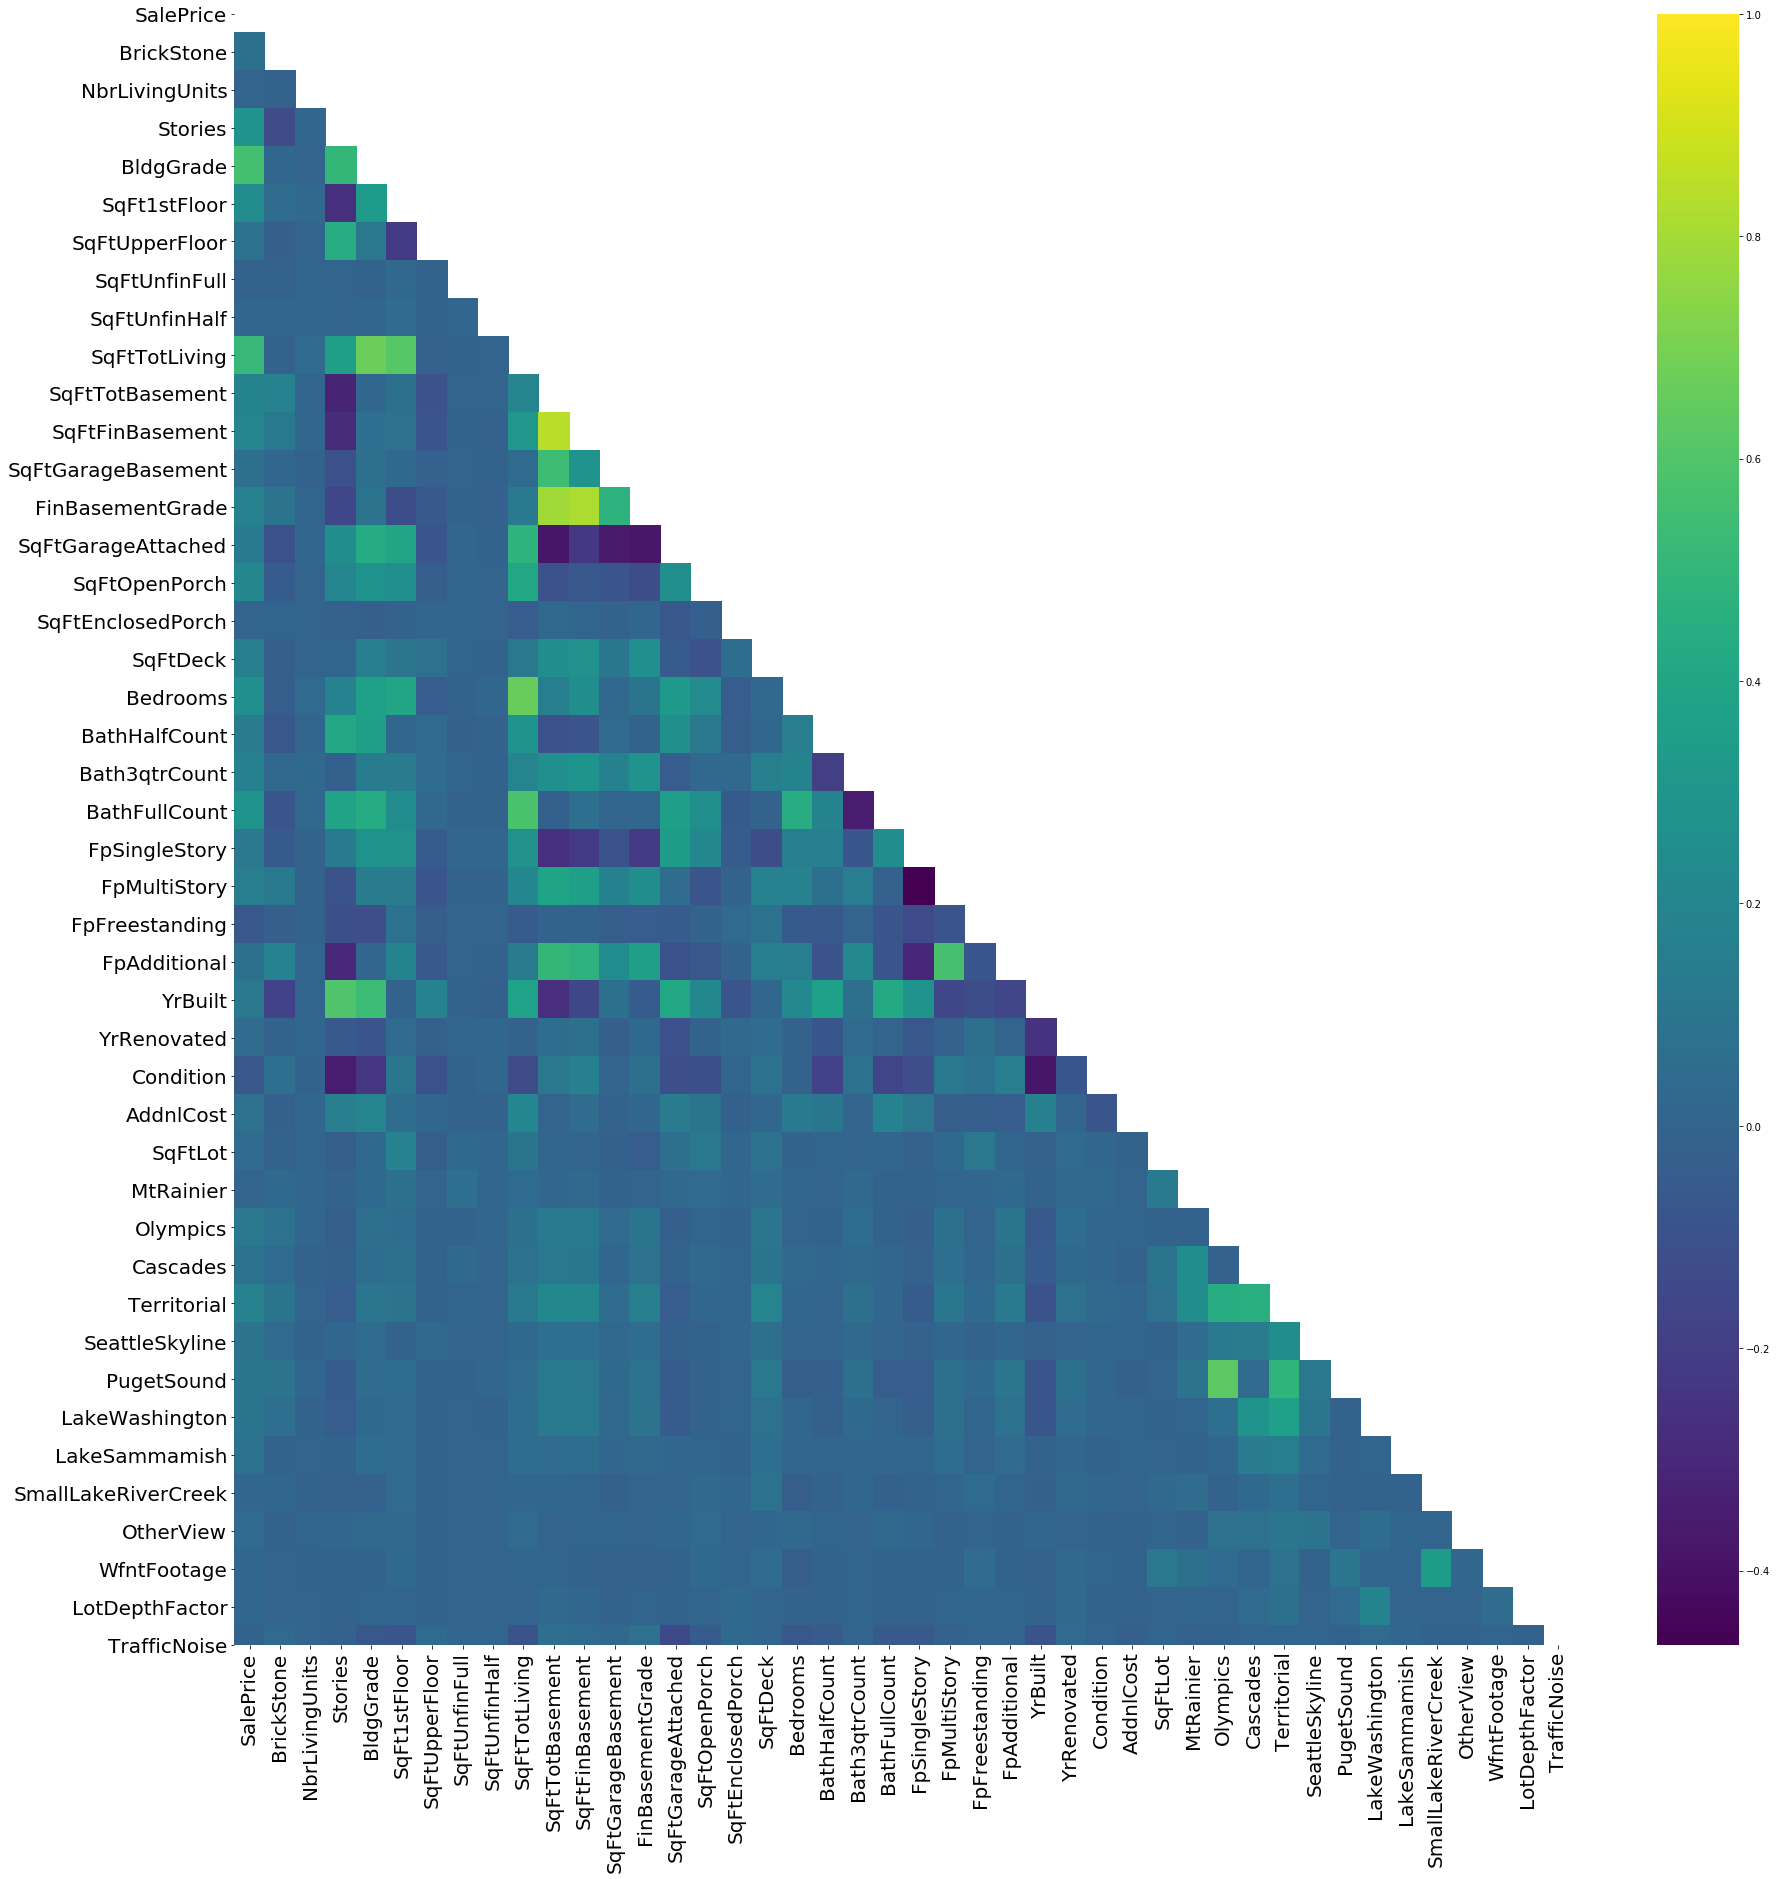

In [3]:
mask = np.triu(np.ones_like(ordtable.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(ordtable.corr(), mask= mask, ax = ax, cmap = 'viridis')

## Correlation matrix heatmap of 20 highest correlated columns

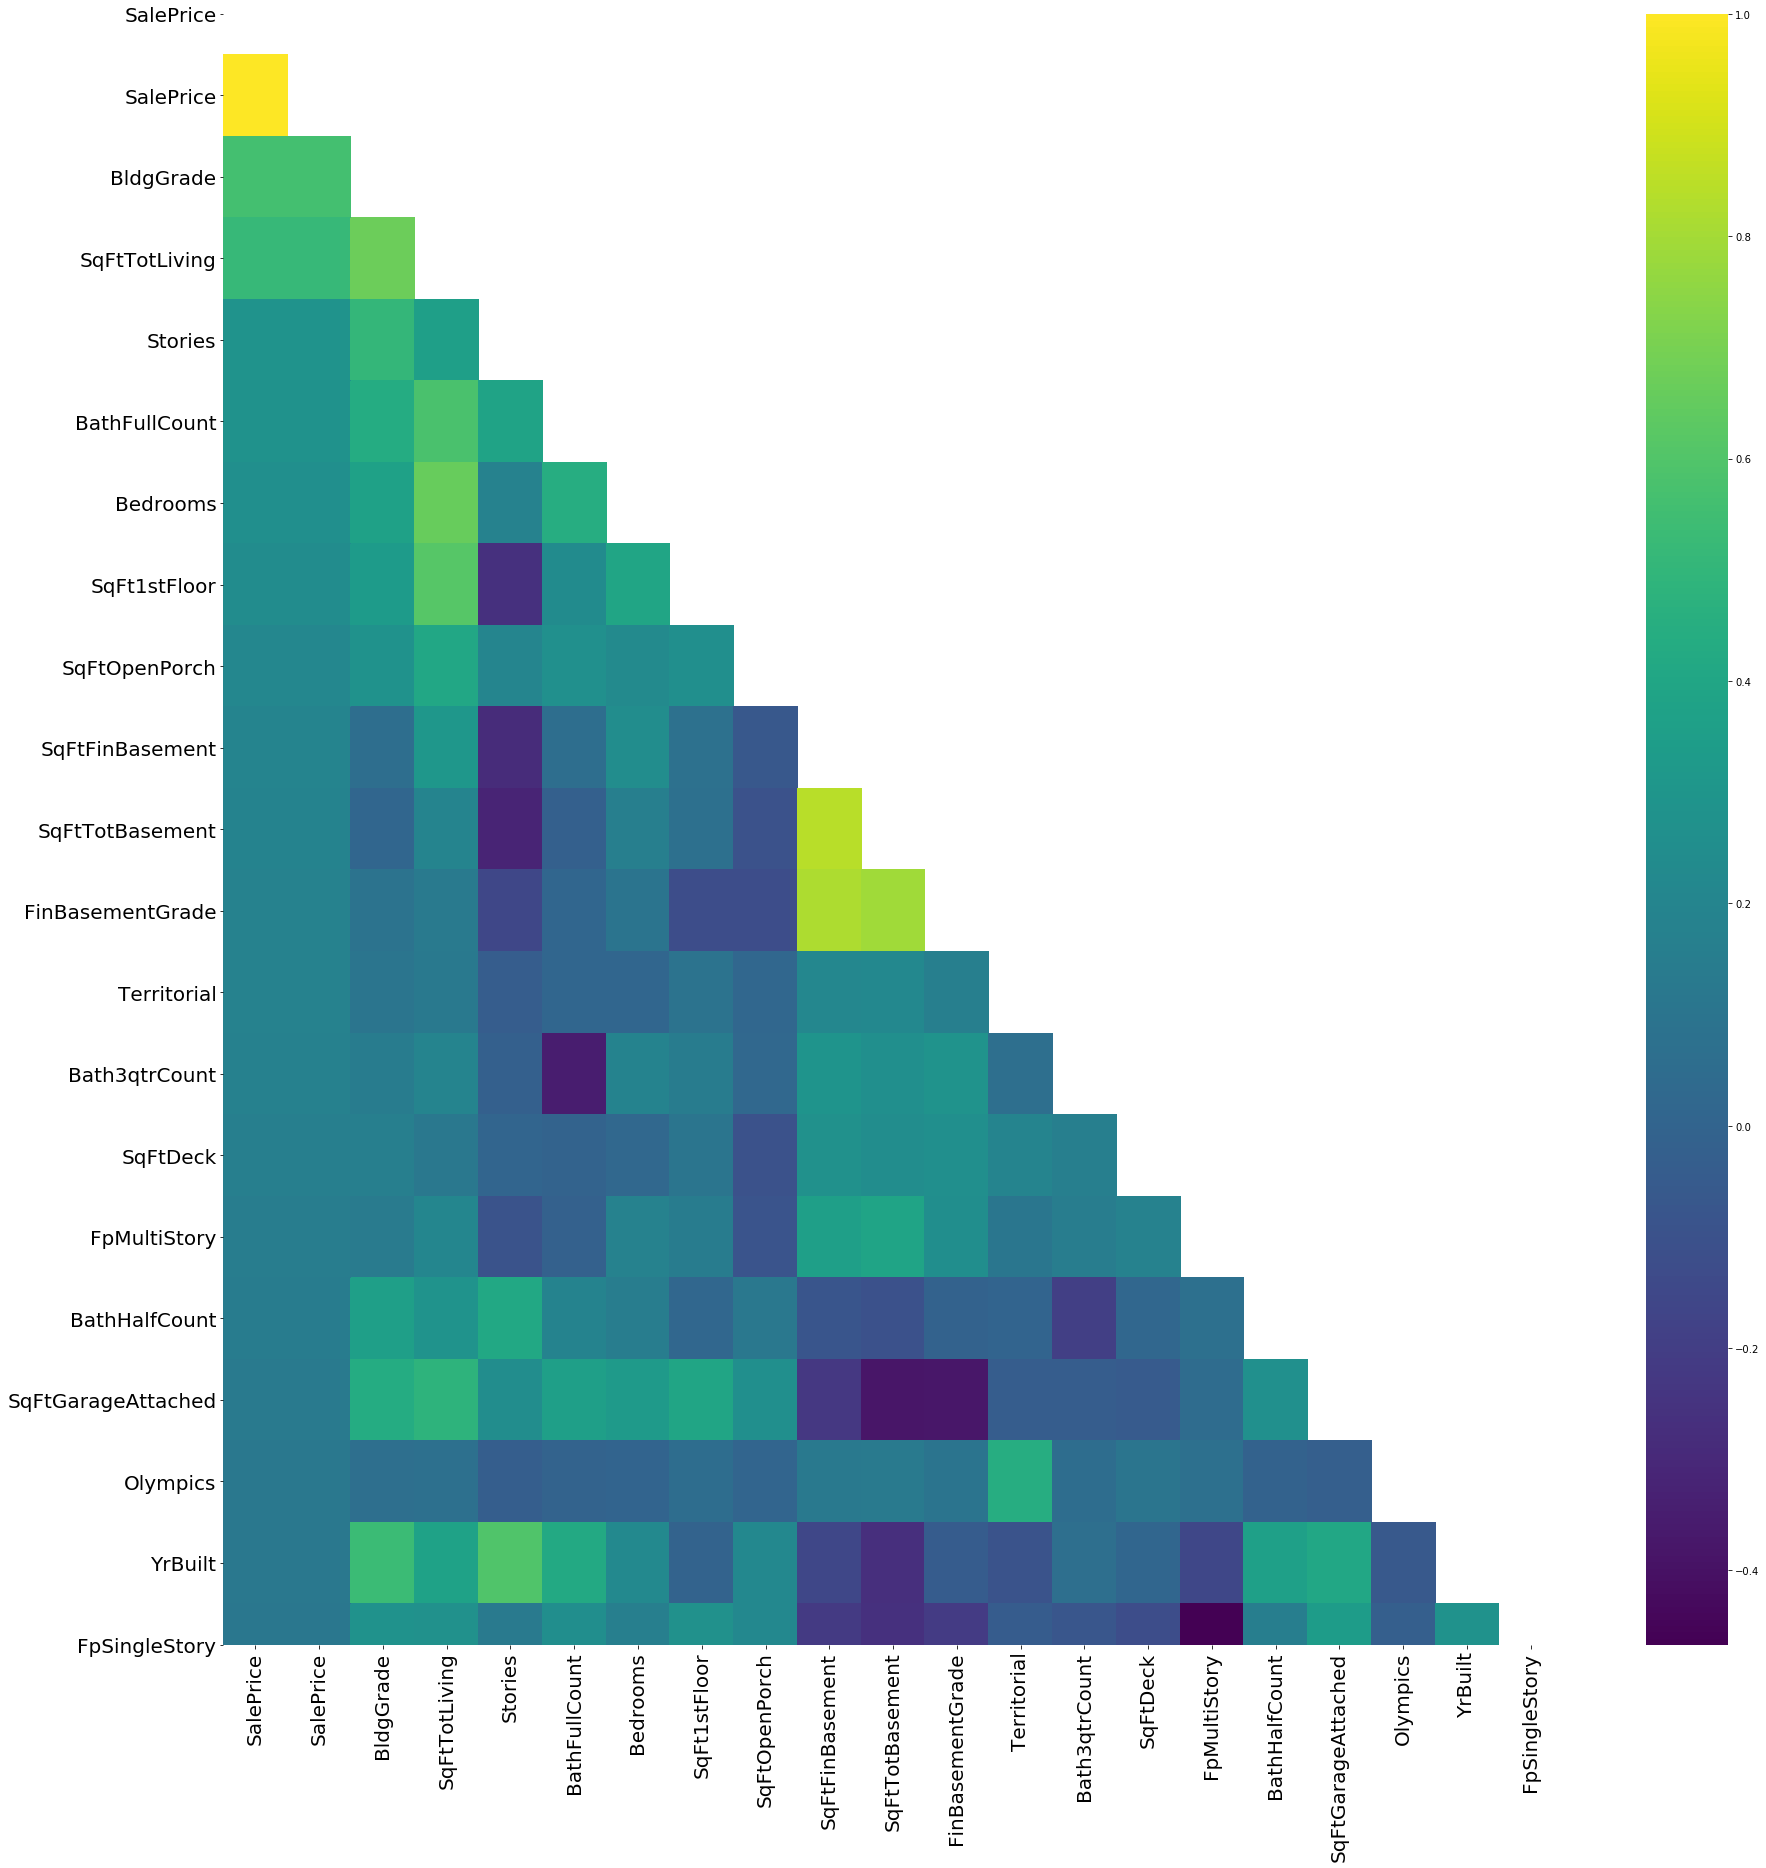

In [4]:
ordcorrs = ordtable.corr()['SalePrice'].abs().sort_values(ascending = False).head(20)
bigcorrs = ordtable[['SalePrice'] + list(ordcorrs.index)]

mask = np.triu(np.ones_like(bigcorrs.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(bigcorrs.corr(), mask= mask, ax = ax, cmap = 'viridis');

I decided not to limit myself to the highest correlated values to `SalePrice` and instead use recursive feature elimination to choose features for me.



## Standardize and scale the features to better interpret coefficients

In [5]:
# pt = preprocessing.StandardScaler()
# stardardords = pd.DataFrame(pt.fit_transform(ordtable))
# stardardords.columns = ordtable.columns

## Let RFE choose my features for me

In [5]:

lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=19)
select = select.fit(X = ordtable.drop('SalePrice', axis=1), y = ordtable['SalePrice'])
predictors = ordtable[ordtable.columns[[True] + list(select.support_) ]]

In [147]:
# ordtable.drop(columns = '', axis = 1, inplace = True)

## Feed the selected predictors into the regression model

In [6]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:45:29   Log-Likelihood:            -3.5265e+05
No. Observations:               25780   AIC:                         7.053e+05
Df Residuals:                   25760   BIC:                         7.055e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.356e+06   1.14e+05     47.014      0.000    5.13e+06    5.58e+06
NbrLivingUnits      -3.788e+04   2.69e+04     -1.408      0.159   -9.06e+04    1.49e+04
Stories              8.733e+04   3239.837     26.955      0.000     8.1e+04    9.37e+04
BldgGrade            1.519e+05   1796.073     84.568      0.000    1.48e+05    1.55e+05
FinBasementGrade     6858.0374    415.512     16.505      0.000    6043.610    7672.465
Bedrooms            -4589.1423   1792.541     -2.560      0.010   -8102.623   -1075.661
Bath3qtrCount         6.73e+04   2722.281     24.721      0.000     6.2e+04    7.26e+04
BathFullCount        7.193e+04   2920.357     24.631      0.000    6.62e+04    7.77e+04
FpMultiStory        -8974.8693   3127.449     -2.870      0.004   -1.51e+04   -2844.893
FpFreestanding      -1.284e+04   5273.659     -2.436      0.015   -2.32e+04   -2507.929
YrBuilt             -3072.6319     58.751    -52.299      0.000   -3187.788   -2957.476
MtRainier           -3.157e+04   6105.022     -5.171      0.000   -4.35e+04   -1.96e+04
Olympics             2.469e+04   5547.793      4.450      0.000    1.38e+04    3.56e+04
Territorial          1.279e+04   2805.233      4.559      0.000    7290.017    1.83e+04
SeattleSkyline       4.669e+04   7871.192      5.931      0.000    3.13e+04    6.21e+04
PugetSound           8874.3134   5286.724      1.679      0.093   -1487.962    1.92e+04
LakeWashington       4.139e+04   5767.289      7.176      0.000    3.01e+04    5.27e+04
LakeSammamish        9.372e+04    1.2e+04      7.799      0.000    7.02e+04    1.17e+05
SmallLakeRiverCreek  2.114e+04   5365.492      3.940      0.000    1.06e+04    3.17e+04
OtherView            2.122e+04   8594.017      2.469      0.014    4373.366    3.81e+04
==============================================================================
Omnibus:                     1866.876   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2980.155
Skew:                           0.571   Prob(JB):                         0.00
Kurtosis:                       4.213   Cond. No.                     1.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1041.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:45:40   Log-Likelihood:            -3.5215e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25759   BIC:                         7.045e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.418e+06   1.12e+05     48.485      0.000     5.2e+06    5.64e+06
NbrLivingUnits      -5.986e+04   2.64e+04     -2.268      0.023   -1.12e+05   -8119.294
Stories              8.634e+04   3177.256     27.174      0.000    8.01e+04    9.26e+04
BldgGrade            1.237e+05   1969.005     62.805      0.000     1.2e+05    1.28e+05
FinBasementGrade     7258.9349    407.659     17.806      0.000    6459.901    8057.969
Bedrooms            -3.156e+04   1948.703    -16.196      0.000   -3.54e+04   -2.77e+04
Bath3qtrCount        4.346e+04   2771.143     15.683      0.000     3.8e+04    4.89e+04
BathFullCount        3.206e+04   3122.055     10.270      0.000    2.59e+04    3.82e+04
FpMultiStory        -2.021e+04   3086.830     -6.546      0.000   -2.63e+04   -1.42e+04
FpFreestanding      -2.441e+04   5184.104     -4.708      0.000   -3.46e+04   -1.42e+04
YrBuilt             -2993.7580     57.666    -51.915      0.000   -3106.787   -2880.729
MtRainier             -3.6e+04   5988.410     -6.012      0.000   -4.77e+04   -2.43e+04
Olympics             2.413e+04   5440.402      4.435      0.000    1.35e+04    3.48e+04
Territorial          7764.6854   2755.374      2.818      0.005    2363.998    1.32e+04
SeattleSkyline       5.205e+04   7720.600      6.742      0.000    3.69e+04    6.72e+04
PugetSound           5465.0191   5185.451      1.054      0.292   -4698.755    1.56e+04
LakeWashington       3.806e+04   5656.573      6.728      0.000     2.7e+04    4.91e+04
LakeSammamish        8.727e+04   1.18e+04      7.405      0.000    6.42e+04     1.1e+05
SmallLakeRiverCreek  1.256e+04   5268.406      2.384      0.017    2232.701    2.29e+04
OtherView            1.849e+04   8428.047      2.194      0.028    1969.169     3.5e+04
SqFtTotalLiving        92.3912      2.881     32.067      0.000      86.744      98.038
==============================================================================
Omnibus:                     1543.854   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2596.835
Skew:                           0.477   Prob(JB):                         0.00
Kurtosis:                       4.227   Cond. No.                     2.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise
0,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0
1,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0
3,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0
4,360000,0,1,1.0,7,1380,0,0,0,1380,0,0,0,0,480,100,0,230,3,0,0,2,0,0,0,0,1996,0,4,0,12200,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2
26102,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0
26103,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0
26104,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0


## Let's check an assumption or two

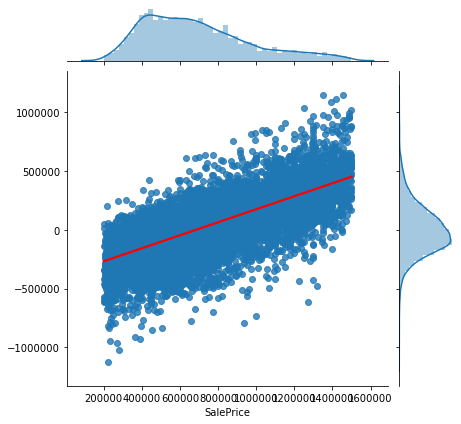

In [10]:
sns.jointplot(predictors['SalePrice'], model.resid, kind = 'reg', line_kws = {'color':"red"});

### The errors look normal


#### but: 
1. We see heteroskadicity. 
2. Our errors are correlated to our target.

# Next steps: 

1. Examine linearity
2. Try to reduce heteroskadacity
3. See what we can do about the correlation of errors to target
4. Try log scaling, or cube scaling on target variables to reduce it's skew.
5. One-hot `BldgGrade`
6. Add other categorical features to improve R<sup>2</sup>



### Map `BldgGrade` to `SalePrice` to see if it's linearly correlated

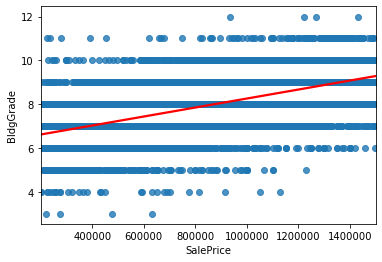

In [11]:
sns.regplot(ordtable.SalePrice, ordtable.BldgGrade, line_kws = {'color':"red"});

`BldgGrade` 9 and 10 are not linearly correlated at all.  In fact, I see weak linear correlation in many categories.

In [12]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise
0,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0
1,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0
3,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0
4,360000,0,1,1.0,7,1380,0,0,0,1380,0,0,0,0,480,100,0,230,3,0,0,2,0,0,0,0,1996,0,4,0,12200,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2
26102,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0
26103,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0
26104,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn import preprocessing as ppc

ohe = ppc.OneHotEncoder(sparse = False)

varsdf = pd.DataFrame(ohe.fit_transform(cattable[['PropertyClass']]),  index = cattable.index)
varsdf.columns = ['PropC' + str(pc) for pc in list(ohe.categories_[0])]
varsdf.drop('PropC1.0', axis= 1, inplace = True)
varsdf

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,PropC2.0,PropC3.0,PropC7.0,PropC8.0,PropC9.0
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
26101,0.0,0.0,0.0,1.0,0.0
26102,0.0,0.0,0.0,1.0,0.0
26103,0.0,0.0,0.0,1.0,0.0
26104,0.0,0.0,0.0,1.0,0.0


In [14]:
ordtable['SubStand2'] = varsdf['PropC2.0'].to_numpy()
ordtable['SubStand3'] = varsdf['PropC3.0'].to_numpy()
ordtable['AveStand7'] = varsdf['PropC7.0'].to_numpy()
ordtable['AbvStand8'] = varsdf['PropC8.0'].to_numpy()
ordtable['AbvStand9'] = varsdf['PropC9.0'].to_numpy()

In [213]:
ordtable.drop(['SubStand2', 'SubStand3', 'AveStand7', 'AbvStand8', 'AbvStand9'], axis =1, inplace = True)

In [15]:
formula = 'SalePrice ~ SqFtTotLiving + SubStand2 + SubStand3 + AveStand7 + AbvStand8 + AbvStand9'
model = smf.ols(formula = formula, data = ordtable).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1579.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:46:57   Log-Likelihood:            -3.5575e+05
No. Observations:               25780   AIC:                         7.115e+05
Df Residuals:                   25773   BIC:                         7.116e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.674e+05   9.72e+04      6.863      0.000    4.77e+05    8.58e+05
SqFtTotLiving   173.1709      1.785     97.008      0.000     169.672     176.670
SubStand2     -1.009e+05   1.94e+05     -0.519      0.604   -4.82e+05     2.8e+05
SubStand3      -2.15e+05   2.57e+05     -0.836      0.403   -7.19e+05    2.89e+05
AveStand7     -3.349e+05   9.79e+04     -3.421      0.001   -5.27e+05   -1.43e+05
AbvStand8      -3.42e+05   9.72e+04     -3.517      0.000   -5.33e+05   -1.51e+05
AbvStand9     -4.672e+05   1.68e+05     -2.775      0.006   -7.97e+05   -1.37e+05
==============================================================================
Omnibus:                     1205.719   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1380.189
Skew:                           0.556   Prob(JB):                    1.98e-300
Kurtosis:                       3.220   Cond. No.                     4.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
subset = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'SubStand2', 'SubStand3', 'AveStand7', 'AbvStand8', 'AbvStand9']])
model = sm.OLS(ordtable['SalePrice'], subset).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1579.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:47:26   Log-Likelihood:            -3.5575e+05
No. Observations:               25780   AIC:                         7.115e+05
Df Residuals:                   25773   BIC:                         7.116e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.674e+05   9.72e+04      6.863      0.000    4.77e+05    8.58e+05
SqFtTotLiving   173.1709      1.785     97.008      0.000     169.672     176.670
SubStand2     -1.009e+05   1.94e+05     -0.519      0.604   -4.82e+05     2.8e+05
SubStand3      -2.15e+05   2.57e+05     -0.836      0.403   -7.19e+05    2.89e+05
AveStand7     -3.349e+05   9.79e+04     -3.421      0.001   -5.27e+05   -1.43e+05
AbvStand8      -3.42e+05   9.72e+04     -3.517      0.000   -5.33e+05   -1.51e+05
AbvStand9     -4.672e+05   1.68e+05     -2.775      0.006   -7.97e+05   -1.37e+05
==============================================================================
Omnibus:                     1205.719   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1380.189
Skew:                           0.556   Prob(JB):                    1.98e-300
Kurtosis:                       3.220   Cond. No.                     4.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
subset2 = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'AveStand7']])
model2 = sm.OLS(ordtable['SalePrice'], subset2).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4728.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:07:24   Log-Likelihood:            -3.5575e+05
No. Observations:               25780   AIC:                         7.115e+05
Df Residuals:                   25777   BIC:                         7.115e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.257e+05   3972.988     81.976      0.000    3.18e+05    3.33e+05
SqFtTotLiving   173.0658      1.785     96.940      0.000     169.567     176.565
AveStand7      7056.6567   1.13e+04      0.624      0.533   -1.51e+04    2.92e+04
==============================================================================
Omnibus:                     1209.975   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1385.683
Skew:                           0.557   Prob(JB):                    1.27e-301
Kurtosis:                       3.220   Cond. No.                     1.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
ordtable[ordtable['AveStand7']==1].mean()

SalePrice              768589.427313
BrickStone                  1.140969
NbrLivingUnits              1.006608
Stories                     2.051762
BldgGrade                   8.233480
SqFt1stFloor             1147.731278
SqFtUpperFloor             86.343612
SqFtUnfinFull               0.418502
SqFtUnfinHalf               0.000000
SqFtTotLiving            2518.370044
SqFtTotBasement           261.343612
SqFtFinBasement           153.083700
SqFtGarageBasement         56.894273
FinBasementGrade            2.211454
SqFtGarageAttached        334.588106
SqFtOpenPorch             160.746696
SqFtEnclosedPorch           5.748899
SqFtDeck                   94.889868
Bedrooms                    3.658590
BathHalfCount               0.544053
Bath3qtrCount               0.638767
BathFullCount               1.927313
FpSingleStory               0.755507
FpMultiStory                0.033040
FpFreestanding              0.006608
FpAdditional                0.035242
YrBuilt                  2008.685022
Y

In [19]:
ordtable[ordtable['AbvStand8']==1].mean()

SalePrice              682401.651418
BrickStone                  3.049024
NbrLivingUnits              1.002252
Stories                     1.535435
BldgGrade                   7.595797
SqFt1stFloor             1214.066050
SqFtUpperFloor             14.144189
SqFtUnfinFull               0.498933
SqFtUnfinHalf               0.540886
SqFtTotLiving            2061.659951
SqFtTotBasement           439.801928
SqFtFinBasement           273.404045
SqFtGarageBasement         81.979142
FinBasementGrade            2.794659
SqFtGarageAttached        256.873469
SqFtOpenPorch              69.969503
SqFtEnclosedPorch           5.322707
SqFtDeck                  125.383938
Bedrooms                    3.399068
BathHalfCount               0.461839
Bath3qtrCount               0.511061
BathFullCount               1.554989
FpSingleStory               0.614245
FpMultiStory                0.265189
FpFreestanding              0.065142
FpAdditional                0.158568
YrBuilt                  1977.491270
Y

In [21]:
subset3 = sm.add_constant(ordtable[
    ['AveStand7']])
model3 = sm.OLS(ordtable['SalePrice'], subset3).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [22]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     42.75
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           6.35e-11
Time:                        14:48:29   Log-Likelihood:            -3.5976e+05
No. Observations:               25780   AIC:                         7.195e+05
Df Residuals:                   25778   BIC:                         7.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.825e+05   1748.166    390.387      0.000    6.79e+05    6.86e+05
AveStand7   8.613e+04   1.32e+04      6.538      0.000    6.03e+04    1.12e+05
==============================================================================
Omnibus:                     2021.957   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2541.282
Skew:                           0.769   Prob(JB):                         0.00
Kurtosis:                       3.047   Cond. No.                         7.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
subset4 = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'AbvStand8']])
model4 = sm.OLS(ordtable['SalePrice'], subset4).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [22]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4728.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:08:13   Log-Likelihood:            -3.5575e+05
No. Observations:               25780   AIC:                         7.115e+05
Df Residuals:                   25777   BIC:                         7.115e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.376e+05   1.19e+04     28.372      0.000    3.14e+05    3.61e+05
SqFtTotLiving   173.0139      1.785     96.930      0.000     169.515     176.512
AbvStand8     -1.189e+04   1.12e+04     -1.065      0.287   -3.38e+04    9987.402
==============================================================================
Omnibus:                     1205.727   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1380.216
Skew:                           0.556   Prob(JB):                    1.95e-300
Kurtosis:                       3.221   Cond. No.                     2.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
from sklearn import preprocessing as ppc

ohe = ppc.OneHotEncoder(sparse = False)

varsdf = pd.DataFrame(ohe.fit_transform(cattable[['PropertyClass']]),  index = cattable.index)
varsdf.columns = ['PropC' + str(pc) for pc in list(ohe.categories_[0])]
varsdf.drop('PropC1.0', axis= 1, inplace = True)
varsdf

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,PropC2.0,PropC3.0,PropC7.0,PropC8.0,PropC9.0
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
26101,0.0,0.0,0.0,1.0,0.0
26102,0.0,0.0,0.0,1.0,0.0
26103,0.0,0.0,0.0,1.0,0.0
26104,0.0,0.0,0.0,1.0,0.0


In [29]:
ohe = ppc.OneHotEncoder(sparse = False)

OhHeatSource = pd.DataFrame(ohe.fit_transform(cattable[['HeatSource']]),  index = cattable.index)
OhHeatSource.columns = ['HSorc' + str(pc) for pc in list(ohe.categories_[0])]
OhHeatSource.drop('HSorc0.0', axis= 1, inplace = True)
OhHeatSource

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,HSorc1.0,HSorc2.0,HSorc3.0,HSorc4.0,HSorc5.0,HSorc6.0,HSorc7.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
26101,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
26103,1.0,0.0,0.0,0.0,0.0,0.0,0.0
26104,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
concat = pd.concat([ordtable, OhHeatSource], axis = 1, sort = False)

In [163]:
cattable

,SaleReason,PropertyClass,HeatSystem,HeatSource,PresentUse,HBUAsIfVacant,HBUAsImproved,WaterSystem,SewerSystem,Access,InadequateParking,StreetSurface,Topography,WfntLocation,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,PowerLines,OtherNuisances,AdjacentGolfFairway,AdjacentGreenbelt
0,1,8,4,3,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
1,1,8,5,2,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
2,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
3,1,8,1,2,29,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
4,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,1,8,5,2,2,1,1,2,1,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
26102,1,8,5,1,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
26103,1,8,6,1,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
26104,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N


In [30]:
ordtable['SqFtPorch'] =(ordtable['SqFtEnclosedPorch'] + ordtable['SqFtOpenPorch'])

In [31]:
ordtable['TotFloorPlan'] = (ordtable['SqFtGarageAttached'] + ordtable['SqFtDeck'] + ordtable['SqFtPorch'] + ordtable['SqFt1stFloor'])

In [32]:
ordtable['PropLot'] = ordtable['TotFloorPlan'] / ordtable['SqFtLot']

In [219]:
ordtable['PropLot'].describe()

count    25780.000000
mean         0.265956
std          0.186291
min          0.000128
25%          0.157552
50%          0.230000
75%          0.326006
max          1.631321
Name: PropLot, dtype: float64

In [33]:
cattable['HBUAsImproved'].value_counts()

1    25352
0      251
2      166
4       11
Name: HBUAsImproved, dtype: int64

In [36]:
ohe = ppc.OneHotEncoder(sparse = False)

HBUAsImp = pd.DataFrame(ohe.fit_transform(cattable[['HBUAsImproved']]),  index = cattable.index)
HBUAsImp.columns = ['HBUA' + str(pc) for pc in list(ohe.categories_[0])]
HBUAsImp.drop('HBUA0.0', axis= 1, inplace = True)
HBUAsImp

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,HBUA1.0,HBUA2.0,HBUA4.0
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
26101,1.0,0.0,0.0
26102,1.0,0.0,0.0
26103,1.0,0.0,0.0
26104,1.0,0.0,0.0


In [37]:
ordtable = pd.concat([ordtable, HBUAsImp], axis = 1, sort = False)

In [34]:
ohe = ppc.OneHotEncoder(sparse = False)

OhPresentUse = pd.DataFrame(ohe.fit_transform(cattable[['PresentUse']]),  index = cattable.index)
OhPresentUse.columns = ['PrstUse' + str(pc) for pc in list(ohe.categories_[0])]
OhPresentUse.drop('PrstUse6.0', axis= 1, inplace = True)
OhPresentUse

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,PrstUse2.0,PrstUse29.0,PrstUse300.0
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
26101,1.0,0.0,0.0
26102,1.0,0.0,0.0
26103,1.0,0.0,0.0
26104,1.0,0.0,0.0


In [223]:
ordtable = pd.concat([ordtable, OhPresentUse], axis= 1, sort= False)

In [40]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise,SubStand2,SubStand3,AveStand7,AbvStand8,AbvStand9,SqFtPorch,TotFloorPlan,PropLot,HBUA1.0,HBUA2.0,HBUA4.0
0,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,810,0.324000,1.0,0.0,0.0
1,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1980,0.377143,1.0,0.0,0.0
2,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,300,2940,0.534643,1.0,0.0,0.0
3,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,690,0.525514,1.0,0.0,0.0
4,360000,0,1,1.0,7,1380,0,0,0,1380,0,0,0,0,480,100,0,230,3,0,0,2,0,0,0,0,1996,0,4,0,12200,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,100,2190,0.179508,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0,1.0,0.0,300,2293,0.208455,1.0,0.0,0.0
26102,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1480,0.177033,1.0,0.0,0.0
26103,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,230,1970,0.132312,1.0,0.0,0.0
26104,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,40,1790,0.289879,1.0,0.0,0.0


In [41]:
predictors['SqFtTotalLiving']= ordtable['SqFtTotLiving']

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1041.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:57:38   Log-Likelihood:            -3.5215e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25759   BIC:                         7.045e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.418e+06   1.12e+05     48.485      0.000     5.2e+06    5.64e+06
NbrLivingUnits      -5.986e+04   2.64e+04     -2.268      0.023   -1.12e+05   -8119.294
Stories              8.634e+04   3177.256     27.174      0.000    8.01e+04    9.26e+04
BldgGrade            1.237e+05   1969.005     62.805      0.000     1.2e+05    1.28e+05
FinBasementGrade     7258.9349    407.659     17.806      0.000    6459.901    8057.969
Bedrooms            -3.156e+04   1948.703    -16.196      0.000   -3.54e+04   -2.77e+04
Bath3qtrCount        4.346e+04   2771.143     15.683      0.000     3.8e+04    4.89e+04
BathFullCount        3.206e+04   3122.055     10.270      0.000    2.59e+04    3.82e+04
FpMultiStory        -2.021e+04   3086.830     -6.546      0.000   -2.63e+04   -1.42e+04
FpFreestanding      -2.441e+04   5184.104     -4.708      0.000   -3.46e+04   -1.42e+04
YrBuilt             -2993.7580     57.666    -51.915      0.000   -3106.787   -2880.729
MtRainier             -3.6e+04   5988.410     -6.012      0.000   -4.77e+04   -2.43e+04
Olympics             2.413e+04   5440.402      4.435      0.000    1.35e+04    3.48e+04
Territorial          7764.6854   2755.374      2.818      0.005    2363.998    1.32e+04
SeattleSkyline       5.205e+04   7720.600      6.742      0.000    3.69e+04    6.72e+04
PugetSound           5465.0191   5185.451      1.054      0.292   -4698.755    1.56e+04
LakeWashington       3.806e+04   5656.573      6.728      0.000     2.7e+04    4.91e+04
LakeSammamish        8.727e+04   1.18e+04      7.405      0.000    6.42e+04     1.1e+05
SmallLakeRiverCreek  1.256e+04   5268.406      2.384      0.017    2232.701    2.29e+04
OtherView            1.849e+04   8428.047      2.194      0.028    1969.169     3.5e+04
SqFtTotalLiving        92.3912      2.881     32.067      0.000      86.744      98.038
==============================================================================
Omnibus:                     1543.854   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2596.835
Skew:                           0.477   Prob(JB):                         0.00
Kurtosis:                       4.227   Cond. No.                     2.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
predictors.drop(columns = 'NbrLivingUnits', axis = 1, inplace = True)

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [44]:
predictors

,SalePrice,Stories,BldgGrade,FinBasementGrade,Bedrooms,Bath3qtrCount,BathFullCount,FpMultiStory,FpFreestanding,YrBuilt,MtRainier,Olympics,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,SqFtTotalLiving
0,550000,3.0,8,0,2,0,1,1,0,1985,0,0,0,0,0,0,0,0,0,1560
1,648500,2.0,8,0,5,0,2,0,0,2005,0,0,0,0,0,0,0,0,0,3300
2,1445000,2.0,9,0,5,1,3,0,0,2018,0,0,0,0,0,0,0,0,0,4920
3,785000,2.0,8,8,3,2,1,0,0,1998,0,0,0,0,0,0,0,0,0,1540
4,360000,1.0,7,0,3,0,2,0,0,1996,0,0,0,0,0,0,0,0,0,1380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,2.0,8,0,5,0,3,0,0,2018,0,0,0,0,0,0,0,0,0,2482
26102,1150000,1.5,7,7,4,1,1,1,0,1945,0,0,0,0,0,0,0,0,0,2910
26103,764500,1.0,8,7,4,0,1,1,0,1955,0,0,0,0,0,0,0,0,0,2900
26104,469000,2.0,9,0,4,0,2,1,0,1990,0,0,0,0,0,0,0,0,0,2420


In [45]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1095.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:00:29   Log-Likelihood:            -3.5215e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25760   BIC:                         7.045e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.355e+06   1.08e+05     49.460      0.000    5.14e+06    5.57e+06
Stories              8.628e+04   3177.388     27.153      0.000       8e+04    9.25e+04
BldgGrade            1.238e+05   1968.197     62.902      0.000     1.2e+05    1.28e+05
FinBasementGrade     7262.8433    407.688     17.815      0.000    6463.752    8061.934
Bedrooms            -3.156e+04   1948.859    -16.196      0.000   -3.54e+04   -2.77e+04
Bath3qtrCount        4.327e+04   2770.074     15.620      0.000    3.78e+04    4.87e+04
BathFullCount        3.192e+04   3121.706     10.227      0.000    2.58e+04     3.8e+04
FpMultiStory         -2.01e+04   3086.694     -6.511      0.000   -2.61e+04    -1.4e+04
FpFreestanding      -2.428e+04   5184.196     -4.683      0.000   -3.44e+04   -1.41e+04
YrBuilt             -2992.5395     57.668    -51.892      0.000   -3105.573   -2879.507
MtRainier           -3.625e+04   5987.929     -6.053      0.000    -4.8e+04   -2.45e+04
Olympics             2.401e+04   5440.588      4.413      0.000    1.33e+04    3.47e+04
Territorial          7819.4911   2755.490      2.838      0.005    2418.577    1.32e+04
SeattleSkyline       5.211e+04   7721.176      6.749      0.000     3.7e+04    6.72e+04
PugetSound           5417.5724   5185.825      1.045      0.296   -4746.936    1.56e+04
LakeWashington       3.809e+04   5657.013      6.733      0.000     2.7e+04    4.92e+04
LakeSammamish        8.728e+04   1.18e+04      7.406      0.000    6.42e+04     1.1e+05
SmallLakeRiverCreek  1.262e+04   5268.771      2.394      0.017    2288.362    2.29e+04
OtherView            1.836e+04   8428.547      2.179      0.029    1844.165    3.49e+04
SqFtTotalLiving        92.2215      2.880     32.016      0.000      86.576      97.867
==============================================================================
Omnibus:                     1545.481   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2597.579
Skew:                           0.478   Prob(JB):                         0.00
Kurtosis:                       4.226   Cond. No.                     2.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
predictors.drop(columns = 'PugetSound', axis = 1, inplace = True)

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1156.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:06:17   Log-Likelihood:            -3.5215e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25761   BIC:                         7.045e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.358e+06   1.08e+05     49.513      0.000    5.15e+06    5.57e+06
Stories              8.626e+04   3177.363     27.149      0.000       8e+04    9.25e+04
BldgGrade            1.238e+05   1968.164     62.909      0.000     1.2e+05    1.28e+05
FinBasementGrade     7260.4832    407.682     17.809      0.000    6461.403    8059.563
Bedrooms            -3.166e+04   1946.823    -16.261      0.000   -3.55e+04   -2.78e+04
Bath3qtrCount        4.336e+04   2768.717     15.660      0.000    3.79e+04    4.88e+04
BathFullCount        3.189e+04   3121.487     10.215      0.000    2.58e+04     3.8e+04
FpMultiStory        -2.009e+04   3086.697     -6.509      0.000   -2.61e+04    -1.4e+04
FpFreestanding      -2.417e+04   5183.197     -4.663      0.000   -3.43e+04    -1.4e+04
YrBuilt             -2994.1805     57.647    -51.940      0.000   -3107.172   -2881.189
MtRainier           -3.611e+04   5986.606     -6.032      0.000   -4.78e+04   -2.44e+04
Olympics             2.691e+04   4680.465      5.749      0.000    1.77e+04    3.61e+04
Territorial          8762.9016   2603.313      3.366      0.001    3660.262    1.39e+04
SeattleSkyline       5.198e+04   7720.248      6.733      0.000    3.69e+04    6.71e+04
LakeWashington       3.694e+04   5549.976      6.657      0.000    2.61e+04    4.78e+04
LakeSammamish        8.614e+04   1.17e+04      7.341      0.000    6.31e+04    1.09e+05
SmallLakeRiverCreek  1.237e+04   5263.548      2.350      0.019    2053.366    2.27e+04
OtherView            1.763e+04   8399.062      2.099      0.036    1165.913    3.41e+04
SqFtTotalLiving        92.2835      2.880     32.045      0.000      86.639      97.928
==============================================================================
Omnibus:                     1547.657   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2601.676
Skew:                           0.479   Prob(JB):                         0.00
Kurtosis:                       4.227   Cond. No.                     2.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
ordtable.rename(columns = {'HBUA1.0':'HBUA1', 'HBUA2.0':'HBUA2', 'HBUA4.0':'HBUA4'})

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise,SubStand2,SubStand3,AveStand7,AbvStand8,AbvStand9,SqFtPorch,TotFloorPlan,PropLot,HBUA1,HBUA2,HBUA4
0,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,810,0.324000,1.0,0.0,0.0
1,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1980,0.377143,1.0,0.0,0.0
2,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,300,2940,0.534643,1.0,0.0,0.0
3,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,690,0.525514,1.0,0.0,0.0
4,360000,0,1,1.0,7,1380,0,0,0,1380,0,0,0,0,480,100,0,230,3,0,0,2,0,0,0,0,1996,0,4,0,12200,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,100,2190,0.179508,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0,1.0,0.0,300,2293,0.208455,1.0,0.0,0.0
26102,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1480,0.177033,1.0,0.0,0.0
26103,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,230,1970,0.132312,1.0,0.0,0.0
26104,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,40,1790,0.289879,1.0,0.0,0.0


In [86]:
predictors['HBUA2'] = ordtable['HBUA2'].to_numpy()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     997.7
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:25:46   Log-Likelihood:            -3.5211e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25758   BIC:                         7.044e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.162e+06   1.11e+05     46.546      0.000    4.94e+06    5.38e+06
Stories              8.581e+04   3175.998     27.019      0.000    7.96e+04     9.2e+04
BldgGrade            1.237e+05   1967.125     62.871      0.000     1.2e+05    1.28e+05
FinBasementGrade     7198.2519    407.303     17.673      0.000    6399.915    7996.589
Bedrooms            -3.132e+04   1944.378    -16.109      0.000   -3.51e+04   -2.75e+04
Bath3qtrCount        4.305e+04   2765.092     15.570      0.000    3.76e+04    4.85e+04
BathFullCount        3.147e+04   3117.290     10.096      0.000    2.54e+04    3.76e+04
FpMultiStory        -2.027e+04   3083.876     -6.571      0.000   -2.63e+04   -1.42e+04
FpFreestanding      -2.391e+04   5176.983     -4.619      0.000   -3.41e+04   -1.38e+04
YrBuilt             -2934.4474     58.035    -50.563      0.000   -3048.200   -2820.695
MtRainier           -3.634e+04   5977.691     -6.079      0.000   -4.81e+04   -2.46e+04
Olympics             2.702e+04   4673.433      5.781      0.000    1.79e+04    3.62e+04
Territorial          8857.3934   2599.490      3.407      0.001    3762.247     1.4e+04
SeattleSkyline       5.236e+04   7708.729      6.792      0.000    3.72e+04    6.75e+04
LakeWashington       3.733e+04   5541.815      6.735      0.000    2.65e+04    4.82e+04
LakeSammamish        8.607e+04   1.17e+04      7.345      0.000    6.31e+04    1.09e+05
SmallLakeRiverCreek  1.237e+04   5255.725      2.354      0.019    2069.304    2.27e+04
OtherView             1.69e+04   8386.994      2.015      0.044     458.460    3.33e+04
SqFtTotalLiving        92.6454      2.878     32.194      0.000      87.005      98.286
HBUA4                 2.61e+05   6.37e+04      4.095      0.000    1.36e+05    3.86e+05
HBUA1                7.923e+04   1.33e+04      5.971      0.000    5.32e+04    1.05e+05
HBUA2                1.776e+05    2.1e+04      8.462      0.000    1.36e+05    2.19e+05
==============================================================================
Omnibus:                     1547.608   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2609.969
Skew:                           0.478   Prob(JB):                         0.00
Kurtosis:                       4.232   Cond. No.                     2.53e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
predictors.drop(columns = 'HBUA4', axis = 1, inplace = True)

In [80]:
predictors.drop(columns = 'HBUA1', axis = 1, inplace = True)

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [84]:
predictors.drop(columns = 'HBUA2', axis = 1, inplace = True)

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [94]:
predictors

,SalePrice,Stories,BldgGrade,FinBasementGrade,Bedrooms,Bath3qtrCount,BathFullCount,FpMultiStory,FpFreestanding,YrBuilt,MtRainier,Olympics,Territorial,SeattleSkyline,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,SqFtTotalLiving,HBUA2
0,550000,3.0,8,0,2,0,1,1,0,1985,0,0,0,0,0,0,0,0,1560,0.0
1,648500,2.0,8,0,5,0,2,0,0,2005,0,0,0,0,0,0,0,0,3300,0.0
2,1445000,2.0,9,0,5,1,3,0,0,2018,0,0,0,0,0,0,0,0,4920,0.0
3,785000,2.0,8,8,3,2,1,0,0,1998,0,0,0,0,0,0,0,0,1540,0.0
4,360000,1.0,7,0,3,0,2,0,0,1996,0,0,0,0,0,0,0,0,1380,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,2.0,8,0,5,0,3,0,0,2018,0,0,0,0,0,0,0,0,2482,0.0
26102,1150000,1.5,7,7,4,1,1,1,0,1945,0,0,0,0,0,0,0,0,2910,0.0
26103,764500,1.0,8,7,4,0,1,1,0,1955,0,0,0,0,0,0,0,0,2900,0.0
26104,469000,2.0,9,0,4,0,2,1,0,1990,0,0,0,0,0,0,0,0,2420,0.0


In [118]:
df_PresentUse = pd.concat([predictors, OhPresentUse], axis=1, sort=False)

In [130]:
df_PresentUse.rename({'PrstUse2.0':'PrstUse2', 'PrstUse29.0':'PrstUse29', 'PrstUse300.0':'PrstUse300'}, axis=1, inplace=True)

In [131]:
df_PresentUse

,SalePrice,Stories,BldgGrade,FinBasementGrade,Bedrooms,Bath3qtrCount,BathFullCount,FpMultiStory,FpFreestanding,YrBuilt,MtRainier,Olympics,Territorial,SeattleSkyline,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,SqFtTotalLiving,HBUA2,PrstUse2,PrstUse29,PrstUse300
0,550000,3.0,8,0,2,0,1,1,0,1985,0,0,0,0,0,0,0,0,1560,0.0,1.0,0.0,0.0
1,648500,2.0,8,0,5,0,2,0,0,2005,0,0,0,0,0,0,0,0,3300,0.0,1.0,0.0,0.0
2,1445000,2.0,9,0,5,1,3,0,0,2018,0,0,0,0,0,0,0,0,4920,0.0,1.0,0.0,0.0
3,785000,2.0,8,8,3,2,1,0,0,1998,0,0,0,0,0,0,0,0,1540,0.0,0.0,1.0,0.0
4,360000,1.0,7,0,3,0,2,0,0,1996,0,0,0,0,0,0,0,0,1380,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,2.0,8,0,5,0,3,0,0,2018,0,0,0,0,0,0,0,0,2482,0.0,1.0,0.0,0.0
26102,1150000,1.5,7,7,4,1,1,1,0,1945,0,0,0,0,0,0,0,0,2910,0.0,1.0,0.0,0.0
26103,764500,1.0,8,7,4,0,1,1,0,1955,0,0,0,0,0,0,0,0,2900,0.0,1.0,0.0,0.0
26104,469000,2.0,9,0,4,0,2,1,0,1990,0,0,0,0,0,0,0,0,2420,0.0,1.0,0.0,0.0


In [132]:
preds = 'SalePrice ~ ' + str(df_PresentUse.columns[1])
for pred in df_PresentUse.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = df_PresentUse).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     953.5
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:46:03   Log-Likelihood:            -3.5210e+05
No. Observations:               25780   AIC:                         7.043e+05
Df Residuals:                   25757   BIC:                         7.044e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.174e+06   1.14e+05     45.519      0.000    4.95e+06     5.4e+06
Stories              8.606e+04   3638.946     23.651      0.000    7.89e+04    9.32e+04
BldgGrade            1.233e+05   1986.885     62.033      0.000    1.19e+05    1.27e+05
FinBasementGrade     7191.8026    461.845     15.572      0.000    6286.561    8097.045
Bedrooms            -3.119e+04   1961.745    -15.897      0.000    -3.5e+04   -2.73e+04
Bath3qtrCount        4.311e+04   2777.170     15.524      0.000    3.77e+04    4.86e+04
BathFullCount        3.162e+04   3116.268     10.147      0.000    2.55e+04    3.77e+04
FpMultiStory        -2.079e+04   3105.845     -6.694      0.000   -2.69e+04   -1.47e+04
FpFreestanding      -2.432e+04   5176.304     -4.698      0.000   -3.45e+04   -1.42e+04
YrBuilt             -2930.2764     59.775    -49.022      0.000   -3047.439   -2813.114
MtRainier           -3.634e+04   5977.024     -6.080      0.000   -4.81e+04   -2.46e+04
Olympics               2.7e+04   4673.389      5.777      0.000    1.78e+04    3.62e+04
Territorial          8854.7882   2600.337      3.405      0.001    3757.981     1.4e+04
SeattleSkyline       5.237e+04   7706.878      6.795      0.000    3.73e+04    6.75e+04
LakeWashington       3.729e+04   5540.708      6.729      0.000    2.64e+04    4.81e+04
LakeSammamish        8.626e+04   1.17e+04      7.363      0.000    6.33e+04    1.09e+05
SmallLakeRiverCreek  1.251e+04   5254.543      2.381      0.017    2212.592    2.28e+04
OtherView            1.659e+04   8385.205      1.979      0.048     157.322     3.3e+04
SqFtTotalLiving        92.7485      3.166     29.294      0.000      86.543      98.954
HBUA2                1.184e+05   1.69e+04      7.008      0.000    8.53e+04    1.51e+05
PrstUse2             6.102e+04   1.61e+04      3.783      0.000    2.94e+04    9.26e+04
PrstUse29            6.031e+04   1.73e+04      3.492      0.000    2.65e+04    9.42e+04
PrstUse300          -2.798e+04   2.07e+04     -1.349      0.177   -6.86e+04    1.27e+04
==============================================================================
Omnibus:                     1559.519   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2622.552
Skew:                           0.481   Prob(JB):                         0.00
Kurtosis:                       4.231   Cond. No.                     2.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
preds = 'SalePrice ~ ' + str(df_PresentUse.columns[1])

In [126]:
preds

'SalePrice ~ Stories'

In [128]:
for pred in df_PresentUse.columns[2:]:
    preds = preds + f' + {pred}'
print(preds)

SalePrice ~ Stories + BldgGrade + FinBasementGrade + Bedrooms + Bath3qtrCount + BathFullCount + FpMultiStory + FpFreestanding + YrBuilt + MtRainier + Olympics + Territorial + SeattleSkyline + LakeWashington + LakeSammamish + SmallLakeRiverCreek + OtherView + SqFtTotalLiving + HBUA2 + PrstUse2.0 + PrstUse29.0 + PrstUse300.0 + BldgGrade + FinBasementGrade + Bedrooms + Bath3qtrCount + BathFullCount + FpMultiStory + FpFreestanding + YrBuilt + MtRainier + Olympics + Territorial + SeattleSkyline + LakeWashington + LakeSammamish + SmallLakeRiverCreek + OtherView + SqFtTotalLiving + HBUA2 + PrstUse2.0 + PrstUse29.0 + PrstUse300.0


In [129]:
list(df_PresentUse)

['SalePrice',
 'Stories',
 'BldgGrade',
 'FinBasementGrade',
 'Bedrooms',
 'Bath3qtrCount',
 'BathFullCount',
 'FpMultiStory',
 'FpFreestanding',
 'YrBuilt',
 'MtRainier',
 'Olympics',
 'Territorial',
 'SeattleSkyline',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',
 'SqFtTotalLiving',
 'HBUA2',
 'PrstUse2.0',
 'PrstUse29.0',
 'PrstUse300.0']

In [5]:
import matplotlib.style as style 
style.available

['_classic_test',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10']

NameError: name 'fig' is not defined

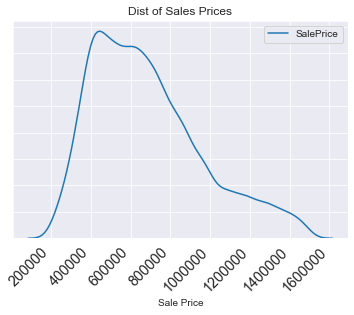

In [11]:
sns.set_style('darkgrid')
sales_dist = sns.kdeplot(ordtable['SalePrice'])
plt.title('Dist of Sales Prices')
plt.tick_params(labelleft=False, left=False)
plt.xlabel('Sale Price')
plt.xticks(rotation=45, horizontalalignment='right',fontsize='x-large');

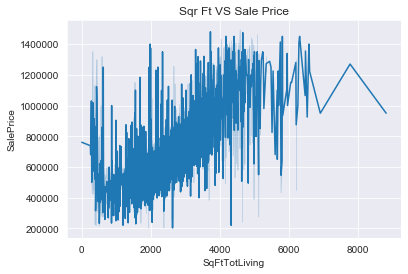

In [13]:
sns.set_style('darkgrid')
sns.lineplot(data=ordtable, x='SqFtTotLiving', y='SalePrice');
plt.title('Sqr Ft VS Sale Price');
plt.savefig('../SqFt_Vs_Sale_Price')

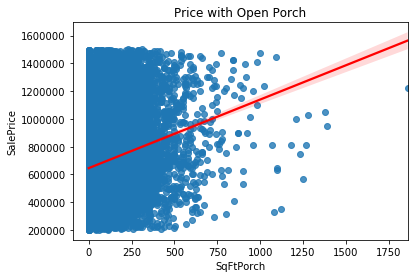

In [178]:
sns.regplot(data=ordtable, x='SqFtPorch',y='SalePrice', line_kws={'color':"red"})
plt.title('Price with Porch');

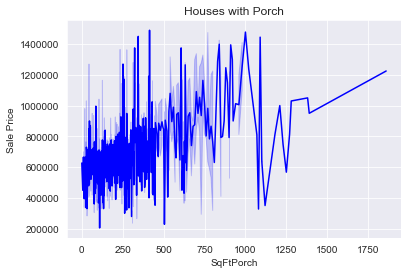

In [204]:
sns.set_style('darkgrid')
sns.lineplot(data=ordtable, x='SqFtPorch', y='SalePrice', color='blue')
plt.title('Houses with Porch')
plt.ylabel('Sale Price');

In [169]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise,SubStand2,SubStand3,AveStand7,AbvStand8,AbvStand9,SqFtPorch,TotFloorPlan,PropLot,HBUA1,HBUA2,HBUA4
0,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,810,0.324000,1.0,0.0,0.0
1,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1980,0.377143,1.0,0.0,0.0
2,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,300,2940,0.534643,1.0,0.0,0.0
3,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,690,0.525514,1.0,0.0,0.0
4,360000,0,1,1.0,7,1380,0,0,0,1380,0,0,0,0,480,100,0,230,3,0,0,2,0,0,0,0,1996,0,4,0,12200,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,100,2190,0.179508,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0,1.0,0.0,300,2293,0.208455,1.0,0.0,0.0
26102,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,1480,0.177033,1.0,0.0,0.0
26103,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,230,1970,0.132312,1.0,0.0,0.0
26104,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,40,1790,0.289879,1.0,0.0,0.0


In [168]:
duplexs = ordtable[['SalePrice','SqFtTotLiving']]
duplexs['PresentUse'] = cattable['PresentUse']
duplexs = duplexs[duplexs['PresentUse']==3]
duplexs['cost_per_sqft'] = duplexs.SalePrice / duplexs.SqFtTotLiving

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [167]:
SingleFamily = ordtable[['SalePrice','SqFtTotLiving']]
SingleFamily['PresentUse'] = cattable['PresentUse']
SingleFamily = SingleFamily[SingleFamily['PresentUse']==2]
SingleFamily['cost_per_sqft'] = SingleFamily.SalePrice / SingleFamily.SqFtTotLiving

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [170]:
duplexs

,SalePrice,SqFtTotLiving,PresentUse,cost_per_sqft
